In [68]:
#TODO: 1) Extend from 3 to n-images
#       2)Make processing time even more quicker 

import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial


### **Importing Drive (Dataset-Small Village-Sensefly)**

In [69]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
plt.figure(figsize=(20,10)) 


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [71]:

class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
  


In [72]:

def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M




In [73]:

def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def ImageBounds(img, H):

    h, w= img.shape[0], img.shape[1]
    p1 = np.dot(H, np.array([0, 0, 1]))
    p2 = np.dot(H, np.array([0, h - 1, 1]))
    p3 = np.dot(H, np.array([w - 1, 0, 1]))
    p4 = np.dot(H, np.array([w - 1, h - 1, 1]))
    x1 = p1[0] / p1[2]
    y1 = p1[1] / p1[2]
    x2 = p2[0] / p2[2]
    y2 = p2[1] / p2[2]
    x3 = p3[0] / p3[2]
    y3 = p3[1] / p3[2]
    x4 = p4[0] / p4[2]
    y4 = p4[1] / p4[2]
    minX = math.ceil(min(x1, x2, x3, x4))
    minY = math.ceil(min(y1, y2, y3, y4))
    maxX = math.ceil(max(x1, x2, x3, x4))
    maxY = math.ceil(max(y1, y2, y3, y4))

    return int(minX), int(minY), int(maxX), int(maxY)
  
  
def Populate_Images(img, accumulator, H, bw):
  


    h, w = img.shape[0], img.shape[1]
    minX, minY, maxX, maxY = ImageBounds(img, H)

    for i in range(minX, maxX + 1):
        for j in range(minY, maxY + 1):
            p = np.dot(np.linalg.inv(H), np.array([i, j, 1]))

            x = p[0]
            y = p[1]
            z = p[2]

            _x = int(x / z)
            _y = int(y / z)

            if _x < 0 or _x >= w - 1 or _y < 0 or _y >= h - 1:
                continue

            if img[_y, _x, 0] == 0 and img[_y, _x, 1] == 0 and img[_y, _x, 2] == 0:
                continue

            wt = 1.0

            if _x >= minX and _x < minX + bw:
                wt = float(_x - minX) /bw
            if _x <= maxX and _x > maxX -bw:
                wt = float(maxX - _x) /bw

            accumulator[j, i, 3] += wt

            for c in range(3):
                accumulator[j, i, c] += img[_y, _x, c] *wt


  

In [74]:

def Image_Stitch(Imagesall, blendWidth, accWidth, accHeight, translation):
    channels=3
    #width=720

    acc = np.zeros((accHeight, accWidth, channels + 1))
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        M = i.position
        img = i.img
        M_trans = translation.dot(M)
        Populate_Images(img, acc, M_trans, blendWidth)
    
    height, width = acc.shape[0], acc.shape[1]

    img = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            weights = acc[i, j, 3]
            if weights > 0:
                for c in range(3):
                    img[i, j, c] = int(acc[i, j, c] / weights)
                    

    Imagefull = np.uint8(img)
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        if count != 0 and count != (len(Imagesall) - 1):
            continue

        M = i.position

        M_trans = translation.dot(M)

        p = np.array([0.5 * width, 0, 1])
        p = M_trans.dot(p)

        
        if count == 0:
            x_init, y_init = p[:2] / p[2]
        
        if count == (len(Imagesall) - 1):
            x_final, y_final = p[:2] / p[2]
    
    
    A = np.identity(3)
    croppedImage = cv2.warpPerspective(
        Imagefull, A, (accWidth, accHeight), flags=cv2.INTER_LINEAR
    )
    displayplot(croppedImage, 'Final Stitched Image')



In [75]:
#!pip uninstall opencv-python
#!pip install opencv-contrib-python===4.4.0.44
#!pip install opencv-python==4.4.1


In [76]:
#print(cv2.__version__)

## **Reading images and Extracting BRISK Keypoints and Descriptors from each**

In [77]:
left_img_pth = '/content/drive/My Drive/Small_Village/IMG_1024.JPG'
mid_img_pth = '/content/drive/My Drive/Small_Village/IMG_1025.JPG'
right_img_pth = '/content/drive/My Drive/Small_Village/IMG_1026.JPG'


left_image_sat= cv2.imread(left_img_pth)
centre_image_sat = cv2.imread(mid_img_pth)
right_image_sat = cv2.imread(right_img_pth)

left = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
centre = cv2.resize(centre_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
right = cv2.resize(right_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)

#left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
#centre = cv2.cvtColor(centre, cv2.COLOR_BGR2GRAY)
#right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

#brisk = cv2.ORB_create(nfeatures = 1000)

#print(ok)

#brisk = cv2.KAZE_create()
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

# find the keypoints with ORB
harris_corners_left_kp = brisk.detect(left,None)
# compute the descriptors with ORB
lpkey, lf = brisk.compute(left, harris_corners_left_kp)

#print(ok)
# find the keypoints with ORB
harris_corners_center_kp = brisk.detect(centre,None)
# compute the descriptors with ORB
cpkey, cf = brisk.compute(centre, harris_corners_center_kp)

# find the keypoints with ORB
harris_corners_right_kp = brisk.detect(right,None)
# compute the descriptors with ORB
rpkey, rf = brisk.compute(right, harris_corners_right_kp)

lp = np.asarray([[p.pt[0], p.pt[1]] for p in lpkey])
cp = np.asarray([[p.pt[0], p.pt[1]] for p in cpkey])
rp = np.asarray([[p.pt[0], p.pt[1]] for p in rpkey])


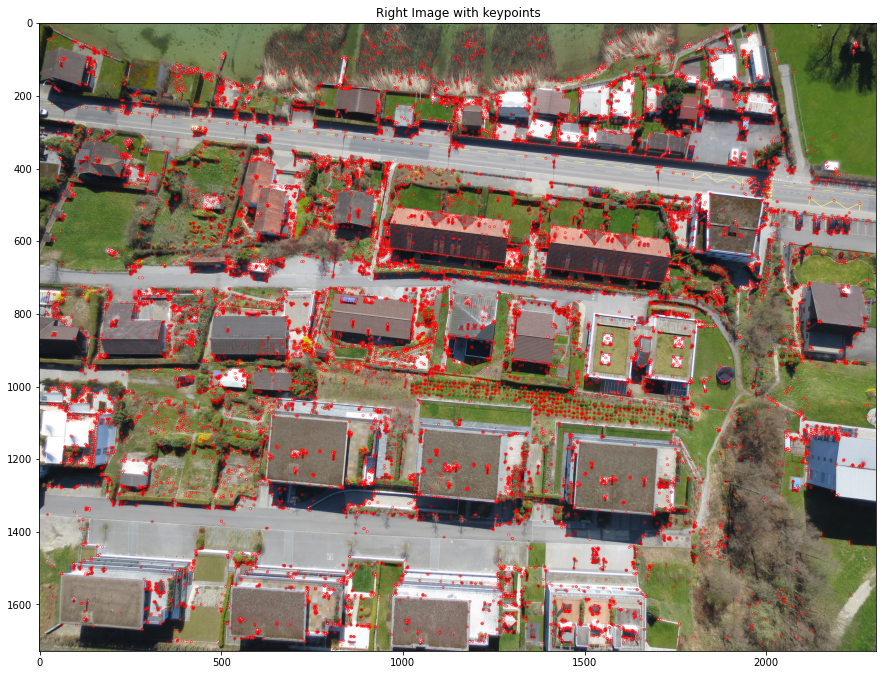

In [78]:

#Display the keypoints
im_with_keypoints = cv2.drawKeypoints(right, rpkey, np.array([]), (0,0,255))   
displayplot(im_with_keypoints,'Right Image with keypoints')




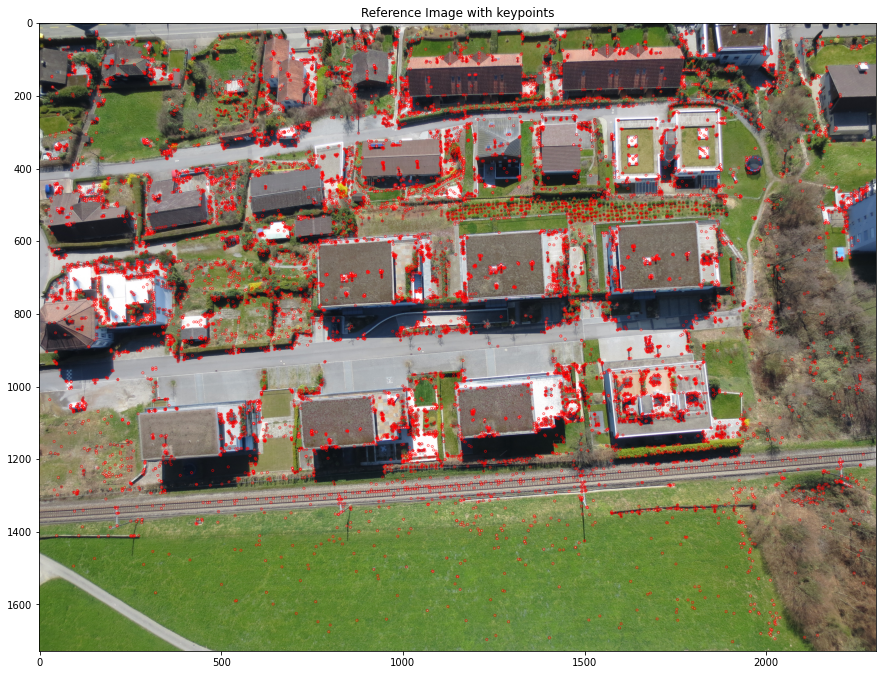

In [79]:

#Display the keypoints
im_with_keypoints = cv2.drawKeypoints(centre, cpkey, np.array([]), (0,0,255))   
displayplot(im_with_keypoints,'Reference Image with keypoints')




## **Image Matching (Tentative)**

In [80]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)


rf = np.float32(rf)
cf = np.float32(cf)


matches_r_c = flann.knnMatch(rf, cf, k=2)


In [81]:
matches_1 = []
ratio = 0.5
# loop over the raw matches
for m in matches_r_c:
  # ensure the distance is within a certain ratio of each
  # other (i.e. Lowe’s ratio test)
  if len(m) == 2 and m[0].distance < m[1].distance * ratio:
      #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_1.append(m[0])

In [82]:
print(len(matches_1))

59


In [83]:
lf = np.float32(lf)
#cf = np.float32(cf)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches_l_c = flann.knnMatch(lf, cf, k=2)

In [96]:
matches_2 = []
ratio = 0.65
# loop over the raw matches
for m in matches_l_c:
  # ensure the distance is within a certain ratio of each
  # other (i.e. Lowe’s ratio test)
  if len(m) == 2 and m[0].distance < m[1].distance * ratio:
      #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_2.append(m[0])

In [97]:
print(len(matches_2))

195


Number of matches 59


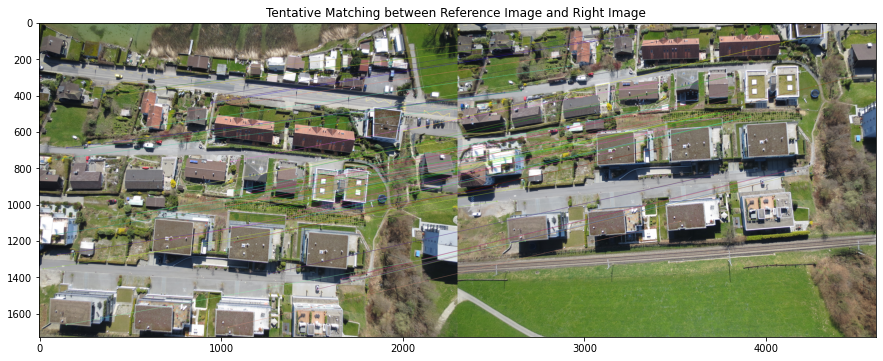

In [86]:
# Euclidean distance to compute pairwise distances between the BRISK descriptors of refernce image and right image
#p=scipy.spatial.distance.cdist(rf,cf, metric='sqeuclidean') 
#matches1=features_matching(p,17000,0.7)
print("Number of matches",len(matches_1))
dispimg1=cv2.drawMatches( right, rpkey,centre, cpkey,matches_1, None,flags=2)
displayplot(dispimg1,'Tentative Matching between Reference Image and Right Image ')

Numberof matches 195


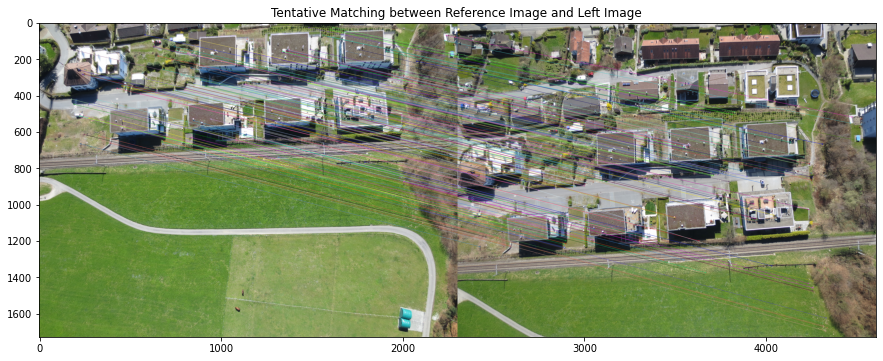

In [98]:
# Euclidean distance to compute pairwise distances between the BRISK descriptors of refernce image and left image
#p=scipy.spatial.distance.cdist(lf,cf, metric='sqeuclidean') 
#matches2=features_matching(p,17000,0.5)
print("Numberof matches",len(matches_2))
dispimg2=cv2.drawMatches(left, lpkey,centre, cpkey, matches_2, None,flags=2)
displayplot(dispimg2,'Tentative Matching between Reference Image and Left Image ')

## **Image Matching (Robust) through RANSAC**

Number of best inliers 30


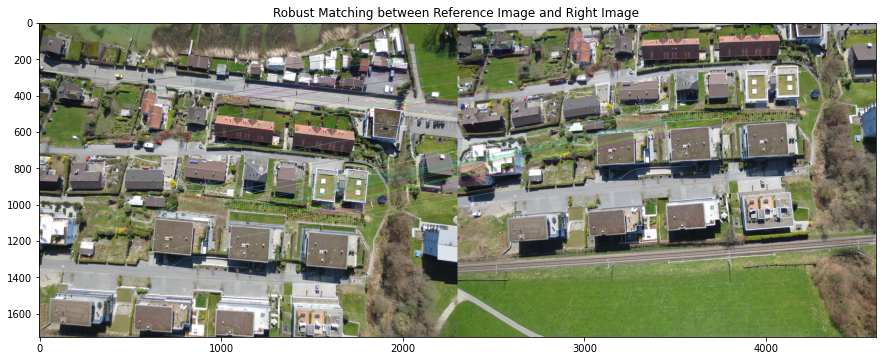

In [88]:

# Estimate homography 1
#Compute H1
im1_pts=np.empty((len(matches_1),2))
im2_pts=np.empty((len(matches_1),2))
for i in range(0,len(matches_1)):
  m = matches_1[i]
  (a_x, a_y) = rpkey[m.queryIdx].pt
  (b_x, b_y) = cpkey[m.trainIdx].pt
  #(a_x, a_y) = rpkey[m[0]].pt
  #(b_x, b_y) = cpkey[m[1]].pt
  im1_pts[i]=(a_x, a_y)
  im2_pts[i]=(b_x, b_y)    
H=compute_Homography(im1_pts,im2_pts) 
#Robustly estimate Homography 1 using RANSAC
H1=RANSAC_alg(rpkey ,cpkey, matches_1,  nRANSAC=1000, RANSACthresh=4)    
global inlier_matchset   
dispimg1=cv2.drawMatches(right, rpkey, centre, cpkey, inlier_matchset, None,flags=2)
displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')

#print(ok)

Number of best inliers 80


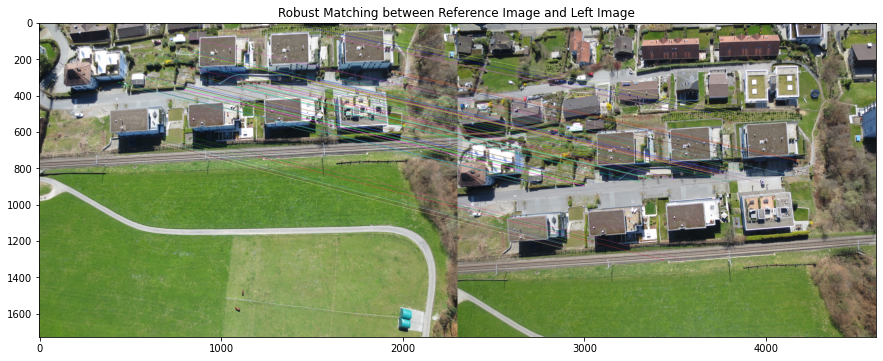

In [99]:

# Estimate homography 2
#Compute H2
im1_pts=np.empty((len(matches_2),2))
im2_pts=np.empty((len(matches_2),2))
for i in range(0,len(matches_2)):
  m = matches_2[i]
  (a_x, a_y) = lpkey[m.queryIdx].pt
  (b_x, b_y) = cpkey[m.trainIdx].pt
  im1_pts[i]=(a_x, a_y)
  im2_pts[i]=(b_x, b_y)
H=compute_Homography(im1_pts,im2_pts) 
#Robustly estimate Homography 2 suing RANSAC  
H2=RANSAC_alg(lpkey ,cpkey, matches_2,  nRANSAC=1000, RANSACthresh=4)
dispimg2=cv2.drawMatches(left, lpkey, centre, cpkey,inlier_matchset, None,flags=2)
displayplot(dispimg2,'Robust Matching between Reference Image and Left Image ')

In [100]:
H1=H1/H1[2,2]
H2=H2/H2[2,2]


In [91]:
def warpThreeImages(img1, img2,img3, H1,H2):
    #img1-centre,img2-left,img3-right
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    h3, w3 = img3.shape[:2]

    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    pts3 = np.float32([[0, 0], [0, h3], [w3, h3], [w3, 0]]).reshape(-1, 1, 2)

    pts2_ = cv2.perspectiveTransform(pts2, H1)
    pts3_ = cv2.perspectiveTransform(pts3, H2)

    #pts = np.concatenate((pts1, pts2_), axis=0)
    pts = np.concatenate((pts1, pts2_,pts3_), axis=0)

    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    result = cv2.warpPerspective(img2, Ht@H1, (xmax-xmin, ymax-ymin))

    result2 = cv2.warpPerspective(img3, Ht@H2, (xmax-xmin, ymax-ymin))
  
    result[t[1]:h1+t[1], t[0]:w1+t[0]] = img1
    result2[t[1]:h1+t[1], t[0]:w1+t[0]] = img1

    #indices = np.where(result==0)[0]

    #print(len(indices))

    #result[indices] = result2[indices]
    result3 = result | result2

    #result[:t[1], :t[0]] = result2[:t[1], :t[0]]

    return result,result2,result3

## **Final Mosaiced Image (with 3 images)**

Text(0.5, 1.0, 'Mosaiced Image')

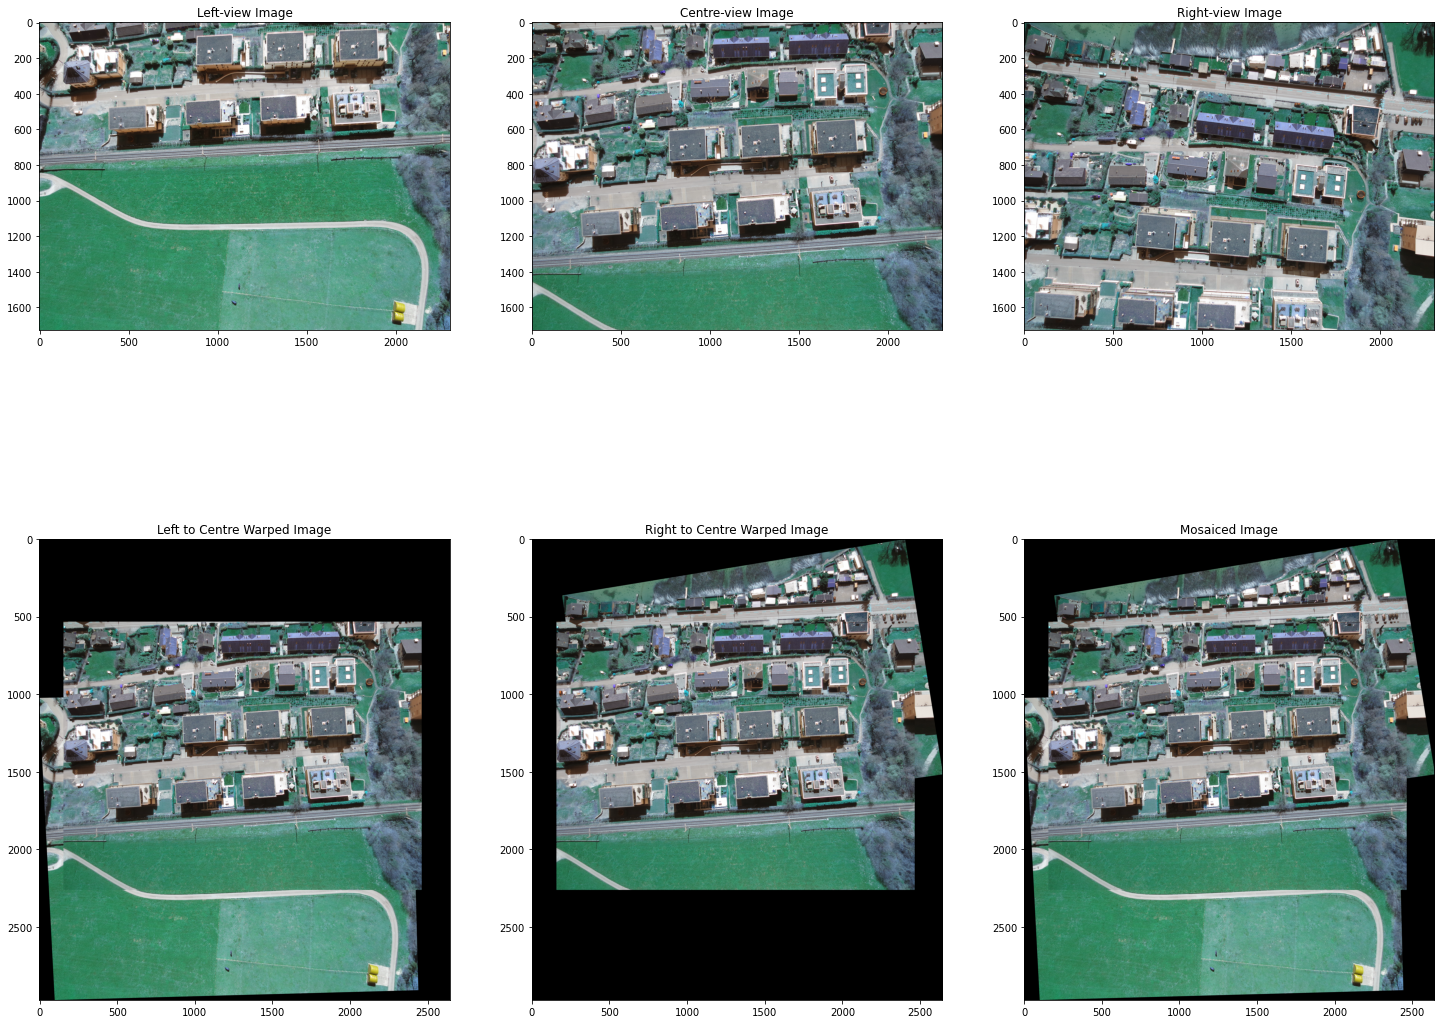

In [101]:
left_centre_warp,right_centre_warp,combined_warp = warpThreeImages(centre, left, right, H2, H1)
plt.figure(figsize = (25,20))
plt.subplot(231)
plt.imshow(left)
plt.title("Left-view Image")
plt.subplot(232)
plt.imshow(centre)
plt.title("Centre-view Image")
plt.subplot(233)
plt.imshow(right)
plt.title("Right-view Image")
plt.subplot(234)
plt.imshow(left_centre_warp)
plt.title("Left to Centre Warped Image")
plt.subplot(235)
plt.imshow(right_centre_warp)
plt.title("Right to Centre Warped Image")
plt.subplot(236)
plt.imshow(combined_warp)
plt.title("Mosaiced Image")

## **(Initial Method) Experiment-1 Image Stitching (Slower and Blurry)**




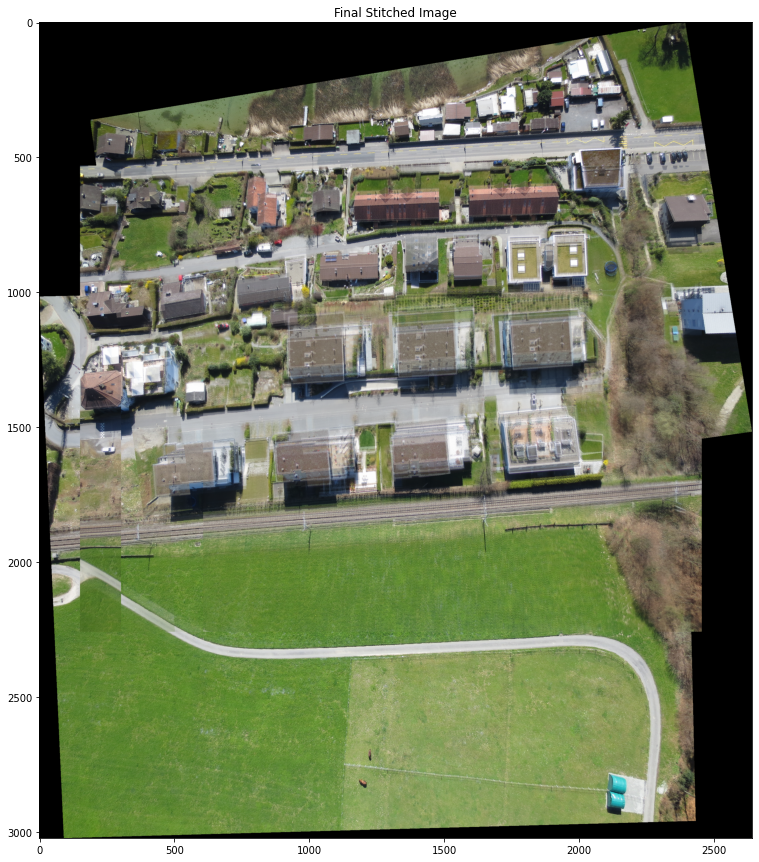

In [191]:
Img1=Image(left,H2)    
Img2=Image(centre,np.eye(3))   
Img3=Image(right,H1)
Imagesall=[Img1,Img2,Img3]

minX = sys.maxsize
minY = sys.maxsize
maxX = 0
maxY = 0

M = np.identity(3)
for i in Imagesall:
    M = i.position
    img = i.img
    _minX, _minY, _maxX, _maxY = ImageBounds(img, M) 
    minX = min(minX, _minX)
    minY = min(minY, _minY)
    maxX = max(maxX, _maxX)
    maxY = max(maxY, _maxY)
    
acc_width = int(math.ceil(maxX) - math.floor(minX))
acc_height = int(math.ceil(maxY) - math.floor(minY))
#transformation matrix so that top-left corner of accumulator image is origin

t = np.array([[1, 0, -minX], [0, 1, -minY], [0, 0, 1]])
Image_Stitch([Img1,Img2,Img3],2000,acc_width, acc_height,  t)    

## **Built-in Image Stitcher**

In [63]:
left_img_pth = '/content/drive/My Drive/Small_Village/IMG_1024.JPG'
mid_img_pth = '/content/drive/My Drive/Small_Village/IMG_1025.JPG'
right_img_pth = '/content/drive/My Drive/Small_Village/IMG_1026.JPG'


left_image_sat= cv2.imread(left_img_pth)
centre_image_sat = cv2.imread(mid_img_pth)
right_image_sat = cv2.imread(right_img_pth)

left = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
centre = cv2.resize(centre_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
right = cv2.resize(right_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)

#imageFiles = ['imageCapture1_0.png','imageCapture2_0.png']
images = []
#for filename in imageFiles:
#    img = cv2.imread(filename)
#    images.append(img)


images.append(left)
images.append(centre)
#images.append()

cv2.ocl.setUseOpenCL(False)
stitcher = cv2.Stitcher_create()
status, result = stitcher.stitch(images)             

#cv2.imwrite('result.png',result)


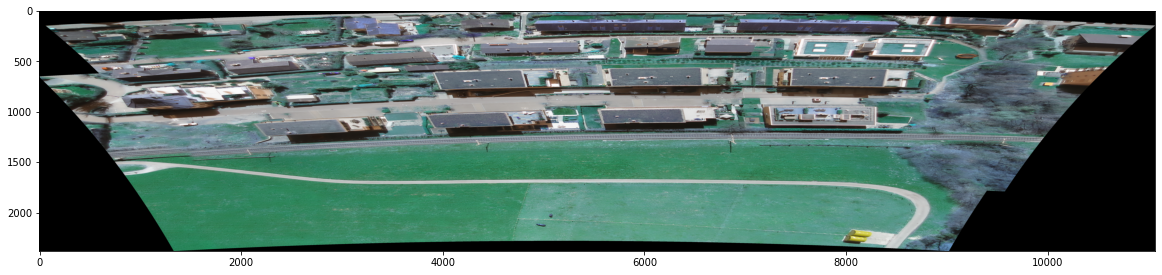

In [64]:
plt.figure(figsize=(20,10))
plt.imshow(result)